In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('../../../notebooks/Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [38]:
# Feature engineering.
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert('US/Eastern')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 04:17:56-04:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 11:43:53-04:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 07:23:26-04:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 17:25:03-04:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-16 22:19:01-04:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [39]:
def haversine_distance(df, src_lat, src_long, tar_lat, tar_long):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers

    phi1 = np.radians(df[src_lat])
    phi2 = np.radians(df[tar_lat])

    delta_phi = phi2 - phi1
    delta_lambda = np.radians(df[tar_long] - df[src_long])

    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c)  # in kilometers
    return d


In [40]:
df['Distance'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df['Distance'].head()

0    2.126312
1    1.392307
2    3.326763
3    1.864129
4    7.231321
Name: Distance, dtype: float64

In [41]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: int64

In [42]:
daysOfWeek = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df['pickup_datetime'].dt.dayofweek
df['DayOfWeek'] = df['DayOfWeek'].map(daysOfWeek) # OR Series.dt.strftime('%a')
df['DayOfWeek'].head()

0      Monday
1    Saturday
2    Saturday
3      Sunday
4      Friday
Name: DayOfWeek, dtype: object

In [43]:
df['AMorPM'] = df['pickup_datetime'].dt.strftime('%p')
df['AMorPM'].head()

0    AM
1    AM
2    AM
3    PM
4    PM
Name: AMorPM, dtype: object

In [61]:
print(df.columns)
cat_cols = ['Hour', 'DayOfWeek', 'AMorPM']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count']
y_col = ['fare_amount']

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'Distance', 'Hour', 'DayOfWeek', 'AMorPM'],
      dtype='object')


In [49]:
# Change categorical columns dtype to 'category'.
for col in cat_cols:
    df[col] = df[col].astype('category')

embedding_sizes = [(size, min(50, (size + 1) // 2)) for size in [len(df[col].cat.categories) for col in cat_cols]]
embedding_sizes


[(24, 12), (7, 4), (2, 1)]

In [114]:
cat_vals = [df[col].cat.codes.values for col in cat_cols]
cat_vals = np.stack(cat_vals, axis=1)
cat_vals = torch.tensor(cat_vals, dtype=torch.int64)
print(cat_vals)

cont_vals = [df[col].values for col in cont_cols]
cont_vals = np.stack(cont_vals, axis=1)
cont_vals = torch.tensor(cont_vals, dtype=torch.float)
print(cont_vals)

y_vals = df[y_col].values
y_vals = torch.tensor(y_vals, dtype=torch.float).reshape(-1, 1)
print(y_vals)

tensor([[ 4,  1,  0],
        [11,  2,  0],
        [ 7,  2,  0],
        ...,
        [14,  3,  1],
        [ 4,  5,  0],
        [12,  2,  1]])
tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000],
        ...,
        [ 40.7498, -73.9886,  40.7078, -74.0115,   3.0000],
        [ 40.7245, -74.0044,  40.7308, -73.9927,   1.0000],
        [ 40.7719, -73.9554,  40.7630, -73.9676,   3.0000]])
tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])


In [2]:
class TabularModel(nn.Module):

    def __init__(self, embedding_szs, num_cont, out_szs, layers, p=0.5):
        super().__init__()
        self.embedding = nn.ModuleList([nn.Embedding(vocab_szs, vec_szs) for vocab_szs, vec_szs in embedding_szs])
        self.dropout = nn.Dropout(p, inplace=True)
        self.normalize = nn.BatchNorm1d(num_cont)

        num_cat = sum([n for i, n in embedding_szs])
        n_in = num_cat + num_cont

        new_layers = []

        for i in layers:
            new_layers.append(nn.Linear(n_in, i))
            new_layers.append(nn.ReLU(inplace=True))
            new_layers.append(nn.Dropout(p))
            new_layers.append(nn.BatchNorm1d(i))
            n_in = i

        new_layers.append(nn.Linear(n_in, out_szs))

        self.layers = nn.Sequential(*new_layers)

    def forward(self, x_cat, x_cont):
        _embeddings = []
        for i, emb in enumerate(self.embedding):
            _embeddings.append(emb(x_cat[:, i]))

        x = torch.cat(_embeddings, 1)
        x = self.dropout(x)

        x_cont = self.normalize(x_cont)
        x = torch.cat([x, x_cont], 1)

        return self.layers(x)

In [117]:
model = TabularModel(embedding_sizes, cont_vals.shape[1], 1, [50, 100, 50], p=0.4)
print(model)

TabularModel(
  (embedding): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(7, 4)
    (2): Embedding(2, 1)
  )
  (dropout): Dropout(p=0.4, inplace=True)
  (normalize): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=50, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [119]:
train_size = 120000
test_size = int(train_size * 0.3)    # 30%

print(train_size, test_size)

# Train-test split.
cat_train = cat_vals[:train_size - test_size]
cat_test = cat_vals[train_size - test_size:]
cont_train = cont_vals[:train_size - test_size]
cont_test = cont_vals[train_size - test_size:]
y_train = y_vals[:train_size - test_size]
y_test = y_vals[train_size - test_size:]

print(cat_train.shape,
      cat_test.shape,
      cont_train.shape,
      cont_test.shape,
      y_train.shape,
      y_test.shape, sep='\n', end='\n\n')

# Train the model.
epochs = 300
losses = []

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(42)

def train():
    for i in range(epochs):

        y_pred = model.forward(cat_train, cont_train)
        loss = torch.sqrt(criterion(y_pred, y_train))

        losses.append(loss)

        if i % 10 == 1:
            print(f"epoch {i} -> loss: {loss}")

        # back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

120000 36000
torch.Size([84000, 3])
torch.Size([36000, 3])
torch.Size([84000, 5])
torch.Size([36000, 5])
torch.Size([84000, 1])
torch.Size([36000, 1])



In [123]:
train()

epoch 1 -> loss: 4.025021553039551
epoch 11 -> loss: 3.9214770793914795
epoch 21 -> loss: 3.8263652324676514
epoch 31 -> loss: 3.7682578563690186
epoch 41 -> loss: 3.733577013015747
epoch 51 -> loss: 3.728602170944214
epoch 61 -> loss: 3.6689023971557617
epoch 71 -> loss: 3.6441612243652344
epoch 81 -> loss: 3.6240220069885254
epoch 91 -> loss: 3.60740327835083
epoch 101 -> loss: 3.6008689403533936
epoch 111 -> loss: 3.5745584964752197
epoch 121 -> loss: 3.564282178878784
epoch 131 -> loss: 3.5372915267944336
epoch 141 -> loss: 3.5294644832611084
epoch 151 -> loss: 3.510519027709961
epoch 161 -> loss: 3.5125982761383057
epoch 171 -> loss: 3.5052027702331543
epoch 181 -> loss: 3.4968252182006836
epoch 191 -> loss: 3.480086326599121
epoch 201 -> loss: 3.4690260887145996
epoch 211 -> loss: 3.456364870071411
epoch 221 -> loss: 3.4575603008270264
epoch 231 -> loss: 3.453247308731079
epoch 241 -> loss: 3.4420440196990967
epoch 251 -> loss: 3.4443166255950928
epoch 261 -> loss: 3.435544252395

Text(0, 0.5, 'RMSE Loss')

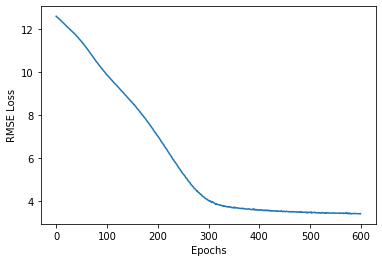

In [127]:
plt.plot(range(epochs * 2), losses)
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')

In [129]:
torch.save(model.state_dict(), "practice_model.pt")

In [132]:
# Test the model.

with torch.no_grad():

    y_pred = model.forward(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_pred, y_test))

    print(loss)

    correct = 0
    for i in range(10):
        print(f'PREDICTED: {y_pred[i]}, ACTUAL: {y_test[i]}')

tensor(3.4304)
PREDICTED: tensor([8.0090]), ACTUAL: tensor([8.5000])
PREDICTED: tensor([6.4786]), ACTUAL: tensor([5.7000])
PREDICTED: tensor([12.1070]), ACTUAL: tensor([12.1000])
PREDICTED: tensor([11.8686]), ACTUAL: tensor([11.3000])
PREDICTED: tensor([13.3403]), ACTUAL: tensor([11.3000])
PREDICTED: tensor([12.3933]), ACTUAL: tensor([11.7000])
PREDICTED: tensor([10.5531]), ACTUAL: tensor([12.1000])
PREDICTED: tensor([6.2138]), ACTUAL: tensor([6.9000])
PREDICTED: tensor([5.8862]), ACTUAL: tensor([9.3000])
PREDICTED: tensor([6.0233]), ACTUAL: tensor([4.5000])
